## Avazu Click-Through Rate Prediction Practice

In [171]:
import csv
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

## Data Import

##### Sample

C1, C14-C21: anonymized categorical variables

In [14]:
with open("/Users/lli2/Downloads/all/train","r") as datafile:
    c = 0
    samplels = []
    while c < 5:
        line = datafile.readline()
        samplels.append(line.strip().split(','))
        c += 1
datafile.close()

pd.DataFrame(samplels[1:], columns=samplels[0]

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79


In [16]:
print(samplels[0])

['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


##### Read Data Function

row:

OrderedDict([('id', '1000009418151094273'), ('click', '0'), ('hour', '14102100'), ('C1', '1005'), ('banner_pos', '0'), ('site_id', '1fbe01fe'), ('site_domain', 'f3845767'), ('site_category', '28905ebd'), ('app_id', 'ecad2386'), ('app_domain', '7801e8d9'), ('app_category', '07d7df22'), ('device_id', 'a99f214a'), ('device_ip', 'ddd2926e'), ('device_model', '44956a24'), ('device_type', '1'), ('device_conn_type', '2'), ('C14', '15706'), ('C15', '320'), ('C16', '50'), ('C17', '1722'), ('C18', '0'), ('C19', '35'), ('C20', '-1'), ('C21', '79')])

In [164]:
def processdata(sample_num, offset=0):
    
    import csv
    
    x_dict = []
    y = []
    
    # open and read file
    with open("/Users/lli2/Downloads/all/train","r") as datafile:
        
        readfile = csv.DictReader(datafile)
        for o in range(offset):
            next(readfile)
        
        i=0
        for row in readfile:
            i += 1
            y.append(int(row['click']))
            
            del row['click'], row['id'], row['device_ip'], row['device_id'], row['hour'], row['site_id'], row['app_id']
        
            # append input to x_dict
            x_dict.append(row)
            
            if i >= sample_num:
                break
            
    datafile.close()
    
    return x_dict, y

In [84]:
x_dict_train, y_train = processdata(100)
x_dict_test, y_test = processdata(20, 100)
x_dict_comb = x_dict_train + x_dict_test

In [116]:
dict_one_hot_encode = DictVectorizer(sparse=False)
x_comb = dict_one_hot_encode.fit_transform(x_dict_comb)
x_train = x_comb[:(100)]
x_test = x_comb[100:]

clf = DecisionTreeClassifier(random_state = 42)
parameters = {'max_depth':[3,8,12,None], 'random_state':[42]}
gridsearch = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, scoring='roc_auc')
gridsearch.fit(x_train, y_train)
clf_best = gridsearch.best_estimator_

prob_test = clf_best.predict_proba(x_test)
#pred_test = clf_best.predict(x_test)

In [ ]:
clf = SGDClassifier(random_state=42, eta0=0.01, loss='log', max_iter=10)
    parameters = {'max_iter':[8,10,15], 'learning_rate':['optimal','adaptive','constant']}
    gridsearch = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, scoring='roc_auc')
    clf_best = gridsearch.best_estimator_

## Modeling

##### Decision Tree

In [165]:
def decision_tree(train_num, test_num):
    
    x_dict_train, y_train = processdata(train_num)
    x_dict_test, y_test = processdata(test_num, train_num)
    x_dict_comb = x_dict_train + x_dict_test
    
    dict_one_hot_encode = DictVectorizer(sparse=False)
    x_comb = dict_one_hot_encode.fit_transform(x_dict_comb)
    x_train = x_comb[:train_num]
    x_test = x_comb[train_num:]
    
    # train decision tree classifier
    clf = DecisionTreeClassifier(random_state = 42)
    parameters = {'max_depth':[3,8,12,None], 'random_state':[42]}
    gridsearch = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, scoring='roc_auc')
    gridsearch.fit(x_train, y_train)
    clf_best = gridsearch.best_estimator_
    
    prob_test = clf_best.predict_proba(x_test)[:,1]
    #pred_test = clf_best.predict(x_test)
    score = roc_auc_score(y_test, prob_test)
    
    #Save file
    decision_tree_model = open("/Users/lli2/Git/kaggle/Avazu Click-Through Rate Prediction/decision_tree_model.sav","wb")
    pickle.dump(clf_best, decision_tree_model)
    decision_tree_model.close()
    print('Decision tree model saved...')
    
    return clf_best, score

In [114]:
decisiontree_best, dt_roc_score = decision_tree(6000, 2000)

Decision tree model saved...


In [115]:
test_score

0.6437887007507261

##### Random Forest

In [166]:
def random_forest(train_num, test_num):
    x_dict_train, y_train = processdata(train_num)
    x_dict_test, y_test = processdata(test_num, train_num)
    x_dict_comb = x_dict_train + x_dict_test
    
    dict_one_hot_encoder = DictVectorizer(sparse=False)
    x_comb = dict_one_hot_encoder.fit_transform(x_dict_comb)
    x_train = x_comb[:train_num]
    x_test = x_comb[train_num:]
    
    # train random forest classifier
    clf = RandomForestClassifier(random_state=42)
    parameters = {'max_depth':[1,3,5,10], 'n_estimators':[50,100], 'random_state':[42]}
    gridsearch = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, scoring='roc_auc')
    gridsearch.fit(x_train, y_train)
    clf_best = gridsearch.best_estimator_
    
    prob_test = clf_best.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test, prob_test)
    
    # save file
    random_forest_model = open("/Users/lli2/Git/kaggle/Avazu Click-Through Rate Prediction/random_forest_model.sav","wb")
    pickle.dump(clf_best, random_forest_model)
    random_forest_model.close()
    print('Random forest model saved...')
    
    return clf_best, score
    

In [124]:
randomforest_best, rf_roc_score = random_forest(6000, 2000)

In [125]:
rf_roc_score

0.6937658095273448

##### SGDClassifier

MLE can be defined as a method for estimating population parameters (such as the mean and variance for Normal, rate (lambda) for Poisson, etc.) from sample data such that the probability (likelihood) of obtaining the observed data is maximized.

In [167]:
def sgd_logistic(train_num, test_num):
    x_dict_train, y_train = processdata(train_num)
    x_dict_test, y_test = processdata(test_num, train_num)
    x_dict_comb = x_dict_train + x_dict_test
    
    dict_one_hot_encoder = DictVectorizer(sparse=False)
    x_comb = dict_one_hot_encoder.fit_transform(x_dict_comb)
    x_train = x_comb[:train_num]
    x_test = x_comb[train_num:]
    
    # train sgd linear regression
    clf = SGDClassifier(random_state=42, eta0=0.01, loss='log', max_iter=10)
    parameters = {'max_iter':[8,10,15], 'learning_rate':['optimal','constant']}
    gridsearch = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, scoring='roc_auc')
    gridsearch.fit(x_train, y_train)
    clf_best = gridsearch.best_estimator_
    #clf.fit(x_train, y_train)
    
    prob_test = clf_best.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test, prob_test)
    
    # save file
    sgd_logistic_model = open("/Users/lli2/Git/kaggle/Avazu Click-Through Rate Prediction/sgd_logistic_model.sav","wb")
    pickle.dump(clf_best, sgd_logistic_model)
    sgd_logistic_model.close()
    print('SGD Logistic model saved...')
    
    return clf_best, score

In [159]:
sgd_best, sgd_roc_score = sgd_logistic(6000, 2000)

In [160]:
sgd_roc_score

0.7078576112875827

In [161]:
sgd_best

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', max_iter=8, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

##### Combine

In [177]:
def main(train_num, test_num):
    decisiontree_best, dt_roc_score = decision_tree(train_num, test_num)
    randomforest_best, rf_roc_score = random_forest(train_num, test_num)
    sgd_best, sgd_roc_score = sgd_logistic(train_num, test_num)
    
    print('Decision Tree AUC: ', dt_roc_score)
    print('Random Forest AUC: ', rf_roc_score)
    print('SGD Logistic AUC: ', sgd_roc_score)
    
    plt.bar(x=['Decision Tree','Random Forest','SGD Logistic'],
            height=[dt_roc_score, rf_roc_score, sgd_roc_score])
    plt.xlabel('Model')
    plt.ylabel('AUC')
    plt.ylim(0.5, 0.8)
    plt.title('Prediction Performance by Different Models')
    return [dt_roc_score, rf_roc_score, sgd_roc_score]

Decision tree model saved...
Random forest model saved...
SGD Logistic model saved...
Decision Tree AUC:  0.6437887007507261
Random Forest AUC:  0.6937658095273448
SGD Logistic AUC:  0.7078576112875827


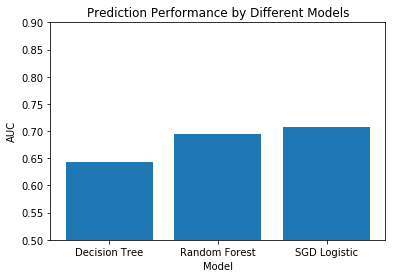

In [178]:
models_results = main(6000, 2000)